## Import modules

In [1]:
# math
import numpy as np
# plots stuff
import matplotlib.pyplot as plt
import matplotlib as mlp
import pandas as pd

from IPython.display import clear_output
import time
from time import sleep

# mlcolvar
import mlcolvar
from mlcolvar.data import DictDataset,DictModule
from mlcolvar.cvs import DeepTDA
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.io import create_dataset_from_files,load_dataframe
from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential, muller_brown_mfep, paletteFessa, paletteCortina

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# torch
import torch
from torch import nn
from torch.utils.data import random_split

torch.manual_seed(42)
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

print ('Torch device: ', device)
torch.set_default_device(device)

Torch device:  cuda


# Functions and Classes


### Custom activation

$$\frac{1}{1 + exp[-px]}$$

Linear activation is not enough for the last layer.
If we add an activation like a sharper sigmoid it helps to collapse the q(x) to constant values in the metastable states.

This way we can also ensure that it never goes below zero if we want to use it as a CV.

TODO: Check if necessary!

In [2]:
class CustomActivation(nn.Module):
    def __init__(self, p):
        super(CustomActivation, self).__init__()
        self.p = p

    def forward(self, x):
        return 1 / (1 + torch.exp(-self.p*(x)))

### Committor guess model: $q_\theta(x)$

Open questions on deltaF and beta, we use them only in muller!!
- $\Delta F$ can make things faster in the earlier stage, we added a keyword to pass it or not

It is helpful also in Alanine actually but of course it complicates things a little bit because you need more informations on the system.

In [3]:
class NN_committor_guess(nn.Module):
    def __init__(self, 
                 nnLayers : list, 
                 p : float = 3,
                 preprocessing : nn.Module = None):
        super(NN_committor_guess, self).__init__() 
        
        # initalize attributes
        self.preprocessing = preprocessing

        # initialize the NN
        modules = []
        for i in range(len(nnLayers)-1):
            print(nnLayers[i], ' --> ', nnLayers[i+1], end=' ')
            if (i<len(nnLayers)-2): 
                modules.append(nn.Linear(nnLayers[i], nnLayers[i+1])) # connection line
                modules.append(nn.Tanh()) # non linearity = activation function of nth nodes
                print('(Tanh)', end = '')
            else:  # last layer only
                modules.append(nn.Linear(nnLayers[i], nnLayers[i+1]))
                modules.append(CustomActivation(p))
                print('')
            print()

        # This actually makes the NN a pytorch object
        self.nn = nn.Sequential(*modules) # the star unpacks the elements in the array

        # what the actual model does
    def forward(self, x : torch.Tensor):
        if self.preprocessing is not None:
            x = self.preprocessing(x)
        q = self.nn(x)
        return q

In [4]:
class NN_committor_zeta(nn.Module):
    def __init__(self, 
                 nnLayers : list, 
                 p : float = 3,
                 preprocessing : nn.Module = None):
        super(NN_committor_zeta, self).__init__() 
        
        # initalize attributes
        self.preprocessing = preprocessing

        # initialize the NN
        modules = []
        for i in range(len(nnLayers)-1):
            print(nnLayers[i], ' --> ', nnLayers[i+1], end=' ')
            if (i<len(nnLayers)-2): 
                modules.append(nn.Linear(nnLayers[i], nnLayers[i+1])) # connection line
                modules.append(nn.Tanh()) # non linearity = activation function of nth nodes
                print('(Tanh)', end = '')
            else:  # last layer only
                modules.append(nn.Linear(nnLayers[i], nnLayers[i+1]))
                print('')
            print()

        # This actually makes the NN a pytorch object
        self.nn = nn.Sequential(*modules) # the star unpacks the elements in the array

        # what the actual model does
    def forward(self, x : torch.Tensor):
        if self.preprocessing is not None:
            x = self.preprocessing(x)
        q = self.nn(x)
        return q




# initialize model
zetamodel = NN_committor_zeta(nnLayers=[51, 32, 32, 1], p=3)   #Two descriptors (sine and cosine) for each torsion, as it is periodic.
zetamodel = zetamodel.to(device)

51  -->  32 (Tanh)
32  -->  32 (Tanh)
32  -->  1 



### Loss Function

Open questions:
- Check if grad needs to be divided due to reduced coordinates (maybe it was only for PDE term)

In [5]:
def loss_function(x : torch.Tensor, 
                  q : torch.Tensor,
                  dx :  torch.Tensor,
                  labels: torch.Tensor, 
                  w: torch.Tensor,
                  mass: torch.Tensor,
                  alpha : float,
                  cell_size: float = None,
                  gamma : float = 10000,
                  delta_f: float = 0,
                  create_graph : bool = True):
    """Compute variational loss for committor optimization with boundary conditions

    Parameters
    ----------
    x : torch.Tensor
        Input of the NN
    q : torch.Tensor
        Committor quess q(x), it is the output of NN
    labels : torch.Tensor
        Labels for states, A and B states for boundary conditions
    w : torch.Tensor
        Reweighing factors. This depends on the simualtion in which the data were collected.
        It is standard reweighing: exp[-beta*V(x)]
    mass : torch.Tensor
        List of masses of all the atoms we are using, for each atom we need to repeat three times for x,y,z
    alpha : float
        Hyperparamer that scales the boundary conditions contribution to loss, i.e. alpha*(loss_bound_A + loss_bound_B)
    cell_size : float
        CUBIC cell size length, used to scale the positions from reduce coordinates to real coordinates, default None 
    gamma : float
        Hyperparamer that scales the whole loss to avoid too small numbers, i.e. gamma*(loss_var + loss_bound) 
        By default 10000
    delta_f : float
        Delta free energy between A (label 0) and B (label 1), units is kBT, by default 0. 
        State B is supposed to be higher in energy.
    create_graph : bool
        Make loss backwardable, deactivate for validation to save memory, default True
    """

    # Create masks to access different states data
    mask_A = torch.nonzero(labels.squeeze() == 0, as_tuple=True) 
    mask_B = torch.nonzero(labels.squeeze() == 1, as_tuple=True) 
    
    # Update weights of basin B using the information on the delta_f
    delta_f = torch.Tensor([delta_f])
    if (delta_f <= 0):
        w[mask_A] = w[mask_A] * torch.exp(delta_f.to(device)) 
    else:
        w[mask_B] = w[mask_B] * torch.exp(-1*delta_f.to(device)) 
    ###### VARIATIONAL PRINICIPLE LOSS ######
    # Each loss contribution is scaled by the number of samples
    
    # We need the gradient of q(x)
    grad_outputs = torch.ones_like(q)
    grad = torch.autograd.grad(q, x, grad_outputs=grad_outputs, retain_graph=True, create_graph=create_graph)[0]
    
    grad_expanded = grad.unsqueeze(1) 
    # print (grad_expanded.shape)
    # print (dx.shape)
    gradall = grad_expanded*dx
    gradall = torch.sum(gradall,axis=2)

    # # TODO this fixes cell size issue
    # if cell_size is not None:
    #     grad = grad / cell_size

    # we sanitize the shapes of mass and weights tensors
    # mass should have size [1, n_atoms*spatial_dims]
    mass = mass.unsqueeze(0)
    # weights should have size [n_batch, 1]
    w = w.unsqueeze(-1)

    # we get the square of grad(q) and we multiply by the weight
    grad_square = torch.sum((torch.pow(gradall, 2)*(1/mass)), axis=1, keepdim=True) * w

    # variational contribution to loss: we sum over the batch
    loss_var = torch.mean(grad_square)

    # boundary conditions
    q_A = q[mask_A]
    q_B = q[mask_B]
    loss_A = torch.mean( torch.pow(q_A, 2))
    loss_B = torch.mean( torch.pow( (q_B - 1) , 2))

    loss = gamma*( loss_var + alpha*(loss_A + loss_B) )

    return loss, [loss_var.detach(), alpha*loss_A.detach(), alpha*loss_B.detach()]

### Compute weights from biased simulations

In [6]:
def compute_weights(dataframe, dataset, beta : float, mixing : bool, mixing_csi : float):
    # Check if we have the potential.bias_bias column and sanitize it
    if 'potential.bias_bias' in dataframe.columns:
        dataframe = dataframe.fillna({'potential.bias_bias': 0})
    else:
        dataframe['potential.bias_bias'] = 0

    # compute weights
    dataframe['weights'] = np.exp(beta * (dataframe['potential.bias_bias']))

    # group data from same iteration under the same label, keep 0 and 1 safe because unbiased!
    # dataframe.loc[np.logical_and(dataframe['labels'] % 2 == 1 , dataframe['labels'] > 1), 'labels'] = dataframe.loc[np.logical_and(dataframe['labels'] % 2 == 1 , dataframe['labels'] > 1), 'labels'] - 1
    # dataframe.loc[dataframe['labels'] > 1, 'labels'] = dataframe.loc[dataframe['labels'] > 1, 'labels'] / 2 + 1

    # get the reweight averages
    for i in np.unique(dataframe['labels'].values):
        # compute average of exp(beta*V) on this simualtions
        coeff = 1 / (np.mean(dataframe.loc[dataframe['labels'] == i, 'weights'].values))

        # we apply weight mixing between iterations: more weight to last iterations   
        if mixing:
            max_iter = np.max(np.unique(dataframe['labels'].values))
            if i>1:
                coeff = coeff * ( mixing_csi**(max_iter - i) * (1 - mixing_csi))
            else:
                coeff = coeff * (mixing_csi**(max_iter - 1))
        print (coeff)    
        # update the weights
        dataframe.loc[dataframe['labels'] == i, 'weights'] = coeff * dataframe.loc[dataframe['labels'] == i, 'weights']
    
    # update labels add weights to torch dataset
    dataset['labels'] = torch.Tensor(dataframe['labels'].values)
    dataset['weights'] = torch.Tensor(dataframe['weights'].values)
    
    return dataframe, dataset

In [7]:
def TranstoUnscaledcoord(x, cell, n_atoms):
    for i in range(3):
        for j in range(i,3*n_atoms+i,3):
            x[:,j]= x[:,j]*cell[i]
    return x


def calculate_dihedral_angle(a, b, c, d, cell):
    AB = b - a
    BC = c - b
    CD = d - c

    # print (AB.shape)
    AB[AB>0.5] =AB[AB>0.5]-1
    AB[AB<-0.5] =AB[AB<-0.5]+1
    BC[BC>0.5] =BC[BC>0.5]-1
    BC[BC<-0.5] =BC[BC<-0.5]+1
    CD[CD>0.5] =CD[CD>0.5]-1
    CD[CD<-0.5] =CD[CD<-0.5]+1

    print (AB.shape)
    AB = TranstoUnscaledcoord(AB, cell, 1)
    BC = TranstoUnscaledcoord(BC, cell, 1)
    CD = TranstoUnscaledcoord(CD, cell, 1)

    n1 = torch.cross(AB, BC)
    n2 = torch.cross(BC, CD)

    UBC= BC/torch.norm(BC,dim=1,keepdim=True)

    n1_normalized = n1 / torch.norm(n1,dim=1,keepdim=True)
    n2_normalized = n2 / torch.norm(n2,dim=1,keepdim=True)

    cos_phi = torch.zeros(len(n1_normalized),1)
    sin_phi= torch.zeros(len(n1_normalized),1)
    for i in range(len(n1_normalized)):
        # print (U1[i],U2[i])
        cos_phi[i,0] = torch.dot(n1_normalized[i], n2_normalized[i])
        sin_phi[i,0]= torch.dot(torch.cross(n1_normalized[i], n2_normalized[i]), UBC[i])
    # cos_theta = torch.dot(n1_normalized, n2_normalized)
    # sin_theta = torch.dot(torch.cross(n1_normalized, n2_normalized),UBC)

    theta = torch.atan2(sin_phi, cos_phi)
    
    return theta, cos_phi, sin_phi


def dihedral_angle_and_derivatives(data_x,id1,id2,id3,id4,cell):

    a= data_x[:,3*id1:(3*id1+3)]
    b= data_x[:,3*id2:(3*id2+3)]
    c= data_x[:,3*id3:(3*id3+3)]
    d= data_x[:,3*id4:(3*id4+3)]

    theta, cos_theta, sin_theta = calculate_dihedral_angle(a, b, c, d,cell)

    # Compute the derivatives of the dihedral angle with respect to the Cartesian coordinates
    grad_outputs= torch.ones_like(cos_theta)
    grad_cos_theta = torch.autograd.grad(cos_theta, data_x, grad_outputs=grad_outputs, retain_graph=True)[0]
    grad_sin_theta = torch.autograd.grad(sin_theta, data_x, grad_outputs=grad_outputs, retain_graph=True)[0]
    # print (grad_sin_theta.shape)
    # n_atoms =int(data_x.shape[0]/3)
    for i in range(3):
        for j in range(i,data_x.shape[1],3):
            grad_cos_theta[:,j]= grad_cos_theta[:,j]/cell[i]
            grad_sin_theta[:,j]= grad_sin_theta[:,j]/cell[i]

    return theta,cos_theta,sin_theta,grad_cos_theta,grad_sin_theta


def angles_all(data_tensor_p,cell):

    phi,cos_phi,sin_phi,grad_cos_phi,grad_sin_phi = dihedral_angle_and_derivatives(data_tensor_p,5,6,7,4,cell)
    psi,cos_psi,sin_psi,grad_cos_psi,grad_sin_psi = dihedral_angle_and_derivatives(data_tensor_p,7,5,4,12,cell)
    # theta,cos_theta,sin_theta,grad_cos_theta,grad_sin_theta = dihedral_angle_and_derivatives(data_tensor_p,2,1,3,4,cell)
    # omega,cos_omega,sin_omega,grad_cos_omega,grad_sin_omega = dihedral_angle_and_derivatives(data_tensor_p,4,6,8,9,cell)
    #gradall= grad_cos_phi+ grad_sin_phi
    # gradall2= torch.stack([grad_sin_phi,grad_cos_phi, grad_sin_psi ,grad_cos_psi,grad_sin_theta,grad_cos_theta,grad_sin_omega,grad_cos_omega],axis=2)

    gradall2= torch.stack([grad_sin_phi,grad_cos_phi,grad_sin_psi,grad_cos_psi],axis=2)
    return torch.hstack((sin_phi,cos_phi,sin_psi,cos_psi)),gradall2

# Workflow template

## Iter 1

### Set T and $k_B$

In [8]:
# temperature in Kelvin
T = 300 
# Boltzmann factor in the RIGHT ENRGY UNITS!
kb = 0.0083144621
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

Beta: 0.4009078751268027 
1/beta: 2.4943386299999997


### Initialize model and optimizer

In [9]:
# initialize model
model = NN_committor_guess(nnLayers=[51, 32, 32, 1], p=3)   #Two descriptors (sine and cosine) for each torsion, as it is periodic.

# initialize the optimizer to optimize over model's parameters
opt = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=0.00001)

# set learnin rate decay scheduler
decayRate = 0.99983
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=decayRate)

# move model to right device
model = model.to(device)

51  -->  32 (Tanh)
32  -->  32 (Tanh)
32  -->  1 



### Load data

In [10]:
################################### SET THINGS HERE ###################################
folder = None
filenames = [
              './COLVAR_positions_49descriptors_reactant_eqm',  
              './COLVAR_positions_49descriptors_1step_product_eqm',
              './COLVAR_tot_l6_test1_cycle0',
              './COLVAR_tot_l2_test1_cycle1',
              './COLVAR_tot_l3_test1_cycle1',
              './COLVAR_tot_l4_test1_cycle1',
              './COLVAR_tot_l6_test1_cycle1',
              './COLVAR_tot_l3_test1_cycle2',
              './COLVAR_tot_l2_test1_cycle3',
              './COLVAR_tot_l2.1_test1_cycle3',
              './COLVAR_tot_l2.2_test1_cycle3',
              './COLVAR_tot_l2.4_test1_cycle3',
              './COLVAR_tot_l2.5_test1_cycle3',
              #'./COLVAR_tot_l3_test1_cycle3',
              './COLVAR_tot_l2.5_test2_cycle0',
              './COLVAR_tot_l3_test2_cycle0',
              './COLVAR_tot_l2.5_test3_cycle0',
              './COLVAR_tot_l3_test3_cycle0',
              './COLVAR_position_bias_test3_cycle1_fromR',
              './COLVAR_position_bias_test3_cycle1_fromI',
            ]

load_args = [
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
             {'start' : 0, 'stop': 100000, 'stride': 5},
            ]             

mixing = False
mixing_csi = 0.3
#######################################################################################

dataset, dataframe = create_dataset_from_files(file_names = filenames,
                                               folder = folder,
                                               create_labels = True,
                                               # filter_args = {'regex': '[A-Z][a-z]*[1-9]*_[A-Z]*[1-9]*.[abc]'},
                                            #    filter_args = {'regex': 'C_Asp197_CA|C_Asp197_C|C_Asp197_O1|C_Asp197_O2|C_subst_O5|C_subst_C1|C_subst_C1H|C_subst_C2|C_subst_O2H|C_subst_C3|C_subst_O3H|C_subst_C4|C_subst_C5|C_subst_O6|C_subst_O6H|C_subst_Ogly|C_subst_O5dash|C_subst_C1dash|C_subst_C2dash|C_subst_C3dash|C_subst_C4dash|C_subst_C5dash|C_subst_O6dash|C_Glu233_C|C_Glu233_O1|C_Glu233_O2|C_Glu233_H|C_Asp300_O1|C_Asp300_O2|C_Water_O|C_subst_O2'},
                                               filter_args = {'regex': 'C_*'},
                                               return_dataframe = True,
                                               load_args=load_args,
                                               verbose = True)

# compute the weight for the reweighing depending on the simualtions
dataframe, dataset = compute_weights(dataframe=dataframe, dataset=dataset, beta=beta, mixing=mixing, mixing_csi=mixing_csi )
# dataset = dataset[:,:93]
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
rng = torch.Generator(device=device)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=rng)

# By default we set the preprocessing to None, later we can initialize it 
preprocessing = None

Class 0 dataframe shape:  (1288, 99)
Class 1 dataframe shape:  (1691, 99)
Class 2 dataframe shape:  (2008, 101)
Class 3 dataframe shape:  (143, 101)
Class 4 dataframe shape:  (2837, 101)
Class 5 dataframe shape:  (1498, 101)
Class 6 dataframe shape:  (257, 101)
Class 7 dataframe shape:  (1300, 101)
Class 8 dataframe shape:  (518, 101)
Class 9 dataframe shape:  (713, 101)
Class 10 dataframe shape:  (1615, 101)
Class 11 dataframe shape:  (809, 101)
Class 12 dataframe shape:  (819, 101)
Class 13 dataframe shape:  (2261, 101)
Class 14 dataframe shape:  (2347, 101)
Class 15 dataframe shape:  (3265, 101)
Class 16 dataframe shape:  (3165, 101)
Class 17 dataframe shape:  (630, 102)
Class 18 dataframe shape:  (818, 102)

 - Loaded dataframe (27982, 103): ['time', 'C_Asp197_CA.a', 'C_Asp197_CA.b', 'C_Asp197_CA.c', 'C_Asp197_C.a', 'C_Asp197_C.b', 'C_Asp197_C.c', 'C_Asp197_O1.a', 'C_Asp197_O1.b', 'C_Asp197_O1.c', 'C_Asp197_O2.a', 'C_Asp197_O2.b', 'C_Asp197_O2.c', 'C_subst_O5.a', 'C_subst_O5.b', 'C

### Visualize training set
Change the quantity to plot of course

### Set masses

In [11]:
# atomic masses of the atoms --> size N_atoms * n_dims
# n_dims = 3

# # put number of atoms for each type and the corresponding atomic mass
# # atoms_map = np.array([[15, 12.011],
# #                       [1, 14.007],
# #                       [5, 15.999],
# #                       [1, 1.008]
# #                      ])

# atoms_map = np.array([[7, 12.011],
#                       [2, 15.999],
#                       [1, 1.008]
#                      ])

# atomic_masses = []
# for i in range(len(atoms_map)):
#     # each mass has to be repeated for each dimension 
#     for n in range( int(atoms_map[i, 0] * n_dims) ):
#         atomic_masses.append(atoms_map[i, 1])

# # make it a tensor
# atomic_masses = torch.Tensor(atomic_masses)


atomic_masses= torch.Tensor([12.011,12.011,12.011,
                             12.011,12.011,12.011,
                             15.999,15.999,15.999,
                             15.999,15.999,15.999,
                             15.999,15.999,15.999,
                             12.011,12.011,12.011,
                             1.008,1.008,1.008,
                             12.011,12.011,12.011,
                             1.008,1.008,1.008,
                             12.011,12.011,12.011,
                             1.008,1.008,1.008,
                             12.011,12.011,12.011,
                             12.011,12.011,12.011,
                             15.999,15.999,15.999,
                             1.008,1.008,1.008,
                             15.999,15.999,15.999,
                             15.999,15.999,15.999,
                             12.011,12.011,12.011,
                             12.011,12.011,12.011,
                             12.011,12.011,12.011,
                             12.011,12.011,12.011,
                             12.011,12.011,12.011,
                             15.999,15.999,15.999,
                             12.011,12.011,12.011,
                             15.999,15.999,15.999,
                             15.999,15.999,15.999,
                             1.008,1.008,1.008,
                             15.999,15.999,15.999,
                             15.999,15.999,15.999,
                             15.999,15.999,15.999,
                             15.999,15.999,15.999,
                             1.008,1.008,1.008])
    
atomic_masses = atomic_masses.to(device)

In [12]:
# computes all the non-repeated pairwise distances
from mlcolvar.core.transform import PairwiseDistances

############################ PARAMETERS ############################ 

n_atoms = 32
PBC = True
scaled_coords = False
# cell = dataframe.filter(regex='cell.ax|cell.by|cell.cz').values[-1]
cell = [83.2473,96.1251,84.7612]
####################################################################

cell = torch.Tensor(cell)
cell = cell.to(device)

preprocessing =  PairwiseDistances(n_atoms=n_atoms,
                                   PBC=PBC,
                                   real_cell=cell,
                                   scaled_coords=scaled_coords)

In [13]:
######################################
##### DON'T RUN THIS CELL ############
######################################

## namelist 
#namelist = ['C_Asp197_CA','C_Asp197_C','C_Asp197_O1','C_Asp197_O2','C_subst_O5','C_subst_C1','C_subst_C1H','C_subst_C2','C_subst_O2H','C_subst_C3','C_subst_O3H','C_subst_C4','C_subst_C5','C_subst_O6','C_subst_O6H','C_subst_Ogly','C_subst_O5dash','C_subst_C1dash','C_subst_C2dash','C_subst_C3dash','C_subst_C4dash','C_subst_C5dash','C_subst_O6dash','C_Glu233_C','C_Glu233_O1','C_Glu233_O2','C_Glu233_H','C_Asp300_O1','C_Asp300_O2','C_Water_O','C_subst_O2','C_subst_O3Hdash','C_Water_OH1','C_Water_OH2']
#natom= len(namelist)
#
#k=-1
#DisnameDict= {}
#for i in range(natom):
#    for j in range(i+1,natom):
#        k=k+1
#        disname= f'D_{namelist[i]}-{namelist[j]}'
#        print (f'{k}, d{i+1}-{j+1}, D_{namelist[i]}-{namelist[j]}')
#        DisnameDict[disname]= k
#
### we need a function to read plumed file
#disnamelist ='D_C_Asp197_CA-C_subst_O5,D_C_Asp197_CA-C_subst_C1,D_C_Asp197_CA-C_subst_C2,D_C_Asp197_CA-C_subst_C3,D_C_Asp197_CA-C_subst_C4,D_C_Asp197_CA-C_subst_C5,D_C_Asp197_CA-C_subst_O6,D_C_Asp197_C-C_Asp197_O1,D_C_Asp197_C-C_Asp197_O2,D_C_Asp197_O1-C_subst_O5,D_C_Asp197_O1-C_subst_C1,D_C_Asp197_O1-C_subst_C2,D_C_Asp197_O1-C_subst_O6H,D_C_Asp197_O2-C_subst_O5,D_C_Asp197_O2-C_subst_C1,D_C_Asp197_O2-C_subst_C2,D_C_Asp197_O2-C_subst_O6H,D_C_subst_O5-C_subst_C1,D_C_subst_O5-C_subst_O5dash,D_C_subst_C1-C_subst_C1H,D_C_subst_C1-C_subst_C2,D_C_subst_C1-C_subst_Ogly,D_C_subst_C1-C_subst_C1dash,D_C_subst_C1-C_Water_O,D_C_subst_C2-C_subst_C2dash,D_C_subst_O2H-C_Asp300_O1,D_C_subst_O2H-C_Asp300_O2,D_C_subst_C3-C_subst_C3dash,D_C_subst_O3H-C_Asp300_O1,D_C_subst_O3H-C_Asp300_O2,D_C_subst_C4-C_subst_C4dash,D_C_subst_C5-C_subst_C5dash,D_C_subst_O6-C_subst_O6dash,D_C_subst_Ogly-C_subst_C4dash,D_C_subst_Ogly-C_Water_O,D_C_subst_O6dash-C_Water_O,D_C_Glu233_C-C_Glu233_O1,D_C_Glu233_C-C_Glu233_O2,D_C_Glu233_O2-C_Water_O,D_C_Water_O-C_Water_OH1,D_C_Water_O-C_Water_OH2'
#
#disnamelist = disnamelist.split(',')
## print (disnamelist)
#
#sellist= []
#for disname in disnamelist:
#    sellist.append(DisnameDict[disname])
#
#print (sellist)

0, d1-2, D_C_Asp197_CA-C_Asp197_C
1, d1-3, D_C_Asp197_CA-C_Asp197_O1
2, d1-4, D_C_Asp197_CA-C_Asp197_O2
3, d1-5, D_C_Asp197_CA-C_subst_O5
4, d1-6, D_C_Asp197_CA-C_subst_C1
5, d1-7, D_C_Asp197_CA-C_subst_C1H
6, d1-8, D_C_Asp197_CA-C_subst_C2
7, d1-9, D_C_Asp197_CA-C_subst_O2H
8, d1-10, D_C_Asp197_CA-C_subst_C3
9, d1-11, D_C_Asp197_CA-C_subst_O3H
10, d1-12, D_C_Asp197_CA-C_subst_C4
11, d1-13, D_C_Asp197_CA-C_subst_C5
12, d1-14, D_C_Asp197_CA-C_subst_O6
13, d1-15, D_C_Asp197_CA-C_subst_O6H
14, d1-16, D_C_Asp197_CA-C_subst_Ogly
15, d1-17, D_C_Asp197_CA-C_subst_O5dash
16, d1-18, D_C_Asp197_CA-C_subst_C1dash
17, d1-19, D_C_Asp197_CA-C_subst_C2dash
18, d1-20, D_C_Asp197_CA-C_subst_C3dash
19, d1-21, D_C_Asp197_CA-C_subst_C4dash
20, d1-22, D_C_Asp197_CA-C_subst_C5dash
21, d1-23, D_C_Asp197_CA-C_subst_O6dash
22, d1-24, D_C_Asp197_CA-C_Glu233_C
23, d1-25, D_C_Asp197_CA-C_Glu233_O1
24, d1-26, D_C_Asp197_CA-C_Glu233_O2
25, d1-27, D_C_Asp197_CA-C_Glu233_H
26, d1-28, D_C_Asp197_CA-C_Asp300_O1
27, d1-

In [13]:
def Generate_Discriptor(xori, cell, na, sellist=None,   ):
    # print (xori.shape[1])
    x= TranstoUnscaledcoord(xori, cell,n_atoms=na )
    x.requires_grad = True
    ## all distances
    d = preprocessing(x)

    grad_outputs= torch.ones_like(d[:,0])
    grad_d_all = []
    if (not sellist):
#        sellist = range(d.shape[1])
#        sellist = []
        sellist = [3,4,6,8,10,11,12,31,32,62,63,65,72,90,91,93,100,118,129,145,146,154,156,206,238,239,252,281,282,294,314,333,364,370,373,457,460,461,469,474,475,478,480,484,487,490,493]
#        sellist = [3,4,6,8,10,11,12,33,34,66,67,69,76,96,97,99,106,126,137,155,156,164,166,178,220,254,255,270,301,302,316,338,359,394,400,403,501,506,507,517,522,523,524,525,528,530,531,532,536,541,546,551]
#        sellist = [3,4,6,8,10,11,12,31,32,62,63,65,72,90,91,93,100,118,129,145,146,154,156,206,238,239,252,281,282,294,314,333,364,370,373,457,460,461,469,474,475,478,480,484,487,490,493]
#        sellist =[3,4,6,8,10,11,12,30,31,60,61,63,70,87,88,90,97,114,125,140,141,149,151,199,230,231,243,271,272,283,302,320,349,355,358,435,437,438,450,453,460,462,464]
        print (sellist)
    for i in sellist:
        grad = torch.autograd.grad(d[:,i], x, grad_outputs=grad_outputs, retain_graph=True)[0]
        grad_d_all.append(grad)
    grad_d= torch.stack(grad_d_all,axis=2)

    # # patch descriptor1
    # patch1 = torch.zeros(grad_d.shape[0],6,grad_d.shape[2])
    # grad_d= torch.cat((grad_d,patch1),dim=1)
    # print (grad_d.shape)

    ## single distance
    #d_angles,grad_eachangle,_all,_oriangles = angles_all(xori,cell)
    d_angles,grad_eachangle = angles_all(xori,cell)
    
    d= torch.cat((d[:,sellist],d_angles),dim=1)
    grad_d= torch.cat((grad_d,grad_eachangle),dim=2)
    print (d.shape)
    print (grad_d.shape)
    return d, grad_d

In [14]:
# # training
# xori = train_dataset[:]['data']
# xori = xori.to(device)
# x= TranstoUnscaledcoord(xori, cell)
# x.requires_grad = True

# if preprocessing is not None:
#     d = preprocessing(x)
# d_use = d[:,[0,1,13,33,39,40,41,42,46,57,58,68]]
# labels = train_dataset[:]['labels']
# w = train_dataset[:]['weights']
# labels = labels.to(device)
# w = w.to(device)

# # validation
# x_valori = val_dataset[:]['data']
# x_valori = x_valori.to(device)
# x_val= TranstoUnscaledcoord(x_valori, cell)
# x_val.requires_grad = True

# if preprocessing is not None:
#     d_val = preprocessing(x_val)
# d_val_use = d_val[:,[0,1,13,33,39,40,41,42,46,57,58,68]]
# labels_val = val_dataset[:]['labels']
# w_val = val_dataset[:]['weights']
# labels_val = labels_val.to(device)
# w_val = w_val.to(device)


In [14]:
# training
xori = train_dataset[:]['data']
xori = xori.to(device)

if preprocessing is not None:
#    d,grad_d= Generate_Discriptor(xori,cell, na=32,sellist= sellist)     # TURN ON THIS LINE IF YOU RUN THE PREVIOUS CELL
    d,grad_d= Generate_Discriptor(xori,cell, na=32)

    grad_d = grad_d.clone().detach()
    d =d.clone().detach()
    d.requires_grad = True

labels = train_dataset[:]['labels']
w = train_dataset[:]['weights']
labels = labels.to(device)
w = w.to(device)

# validation
x_valori = val_dataset[:]['data']
x_valori = x_valori.to(device)
if preprocessing is not None:
#    d_val,grad_d_val= Generate_Discriptor(x_valori,cell, na=32,sellist= sellist)  # TURN ON THIS LINE IF YOU RUN THE PREVIOUS CELL
    d_val,grad_d_val= Generate_Discriptor(x_valori,cell, na=32)
    
    grad_d_val = grad_d_val.clone().detach()
    d_val =d_val.clone().detach()
    d_val.requires_grad = True
labels_val = val_dataset[:]['labels']
w_val = val_dataset[:]['weights']
labels_val = labels_val.to(device)
w_val = w_val.to(device)


[3, 4, 6, 8, 10, 11, 12, 31, 32, 62, 63, 65, 72, 90, 91, 93, 100, 118, 129, 145, 146, 154, 156, 206, 238, 239, 252, 281, 282, 294, 314, 333, 364, 370, 373, 457, 460, 461, 469, 474, 475, 478, 480, 484, 487, 490, 493]
torch.Size([25183, 3])
torch.Size([25183, 3])
torch.Size([25183, 51])
torch.Size([25183, 96, 51])
[3, 4, 6, 8, 10, 11, 12, 31, 32, 62, 63, 65, 72, 90, 91, 93, 100, 118, 129, 145, 146, 154, 156, 206, 238, 239, 252, 281, 282, 294, 314, 333, 364, 370, 373, 457, 460, 461, 469, 474, 475, 478, 480, 484, 487, 490, 493]
torch.Size([2799, 3])
torch.Size([2799, 3])
torch.Size([2799, 51])
torch.Size([2799, 96, 51])


### Optimization loop

EPOCH: 49800 	 LOSS: 0.004742818617605411 	 VAR: 4.718298614707922e-08 	 A: 5.484734398446293e-11 	 B: 1.9035268499042483e-10
EPOCH: 49800 	 LOSS_val: 0.003793373389487038 	 VAR_val: 3.7851240554884074e-08 	 A_val: 1.6303676828548938e-11 	 B_val: 6.618966315776109e-11


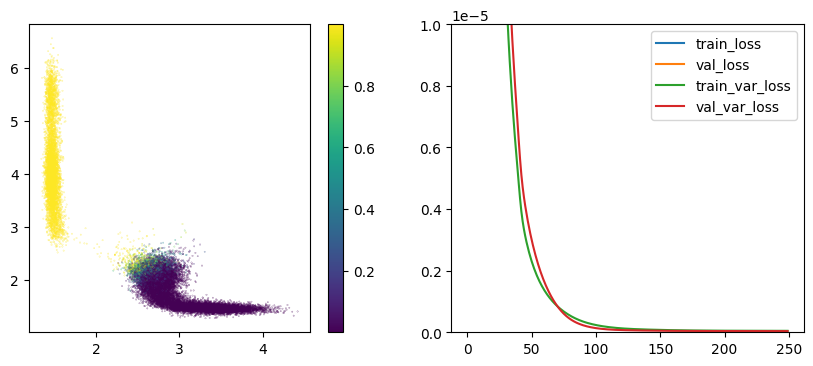

In [15]:
n_epochs = 50000
log_every = 200
alpha_loss = 1e1



losslog= {}
losslog['train']= []
losslog['val'] =[]

model=model.to(torch.float64)
# TODO make loss function a class!

for epoch in range(n_epochs): 

    q = model(d)

    loss, monitor = loss_function(x=d,
                                  q=q,
                                  dx= grad_d,
                                  labels=labels,
                                  w=w,
                                  mass=atomic_masses,
                                  gamma= 100000,
                                  delta_f = -8.35,    #deltaG (product - reactant), in kT unit
                                  alpha=alpha_loss)
    
    # optimize
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()



    # print log
    if epoch % log_every == 0:
        q_val = model(d_val)
        loss_val, monitor_val = loss_function(x=d_val,
                                q=q_val,
                                dx= grad_d_val,
                                labels=labels_val,
                                w=w_val,
                                mass=atomic_masses,
                                alpha=alpha_loss,
                                gamma= 100000,
                                delta_f = -8.35,     #deltaG (product - reactant), in kT unit
                                create_graph=False)

        losslog['train'].append((loss.detach().cpu().numpy(),monitor[0].detach().cpu().numpy()))
        losslog['val'].append((loss_val.detach().cpu().numpy(), monitor_val[0].detach().cpu().numpy()))  
    
        with torch.no_grad():        
            clear_output(wait=True)
            print(f'EPOCH: {epoch} \t LOSS: {loss.cpu().numpy()} \t VAR: {monitor[0].cpu().numpy()} \t'
                            f' A: {monitor[1].cpu().numpy()} \t B: {monitor[2].cpu().numpy()}')
            print(f'EPOCH: {epoch} \t LOSS_val: {loss_val.cpu().numpy()} \t VAR_val: {monitor_val[0].cpu().numpy()} '
                                f'\t A_val: {monitor_val[1].cpu().numpy()} \t B_val: {monitor_val[2].cpu().numpy()}')


        fig, axs = plt.subplots(ncols = 2, figsize=(10,4))

        ax= axs[0]
        im1=ax.scatter(d[:,10].detach().cpu(),d[:,21].detach().cpu(),c=q.cpu().squeeze().detach().numpy(),s=0.1,marker='.')
        # plt.tricontour(x.cpu().detach()[:,0],x.cpu().detach()[:,1],c=q.cpu().squeeze().detach().numpy(),levels=20)

        # divider = make_axes_locatable(ax1)
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, ax=ax, orientation='vertical')

        ax= axs[1]
        ax.plot(range(len(losslog['train'])),np.array(losslog['train'])[:,0],label='train_loss')
        ax.plot(range(len(losslog['val'])),np.array(losslog['val'])[:,0],label='val_loss')
        ax.plot(range(len(losslog['train'])),np.array(losslog['train'])[:,1],label='train_var_loss')
        ax.plot(range(len(losslog['val'])),np.array(losslog['val'])[:,1],label='val_var_loss')
        ax.legend()
        ax.set_ylim(0,0.00001)
        plt.show()

        traced_model = torch.jit.trace(model, d[0,:])
        traced_model.save(f'tracesave_test3_cycle2/model_committor_cycle2_epoch{epoch}.pt')
            
    lr_scheduler.step()

In [16]:
plt.plot(range(len(losslog['train'])),np.array(losslog['train'])[:,0],label='train_loss')
plt.plot(range(len(losslog['val'])),np.array(losslog['val'])[:,0],label='val_loss')
plt.plot(range(len(losslog['train'])),np.array(losslog['train'])[:,1],label='train_var_loss')
plt.plot(range(len(losslog['val'])),np.array(losslog['val'])[:,1],label='val_var_loss')
plt.legend()
plt.ylim(0,0.0000001)
plt.xlim(0,250)
print (np.min(np.array(losslog['val'])[:,0]))
plt.savefig('test3_cycle2.png')

0.003793373389487038


### Deploy model for PLUMED
It has to be in float32!

In [17]:
model_name = 'model_test3_cycle2'
model= torch.jit.load('./tracesave_test3_cycle2/model_committor_cycle2_epoch49800.pt')
# save model parameters for future optimization strarting from here
torch.save(model.state_dict(), f'{model_name}.para')

# save frozen JIT model for PLUMED
model = model.to(torch.float32)
fake_input =d[0,:].to(device).to(torch.float32)
traced_model = torch.jit.trace(model, fake_input)
traced_model.save(f'{model_name}.pt')

/home/sudas@iit.local/miniconda3/envs/mlcolvar/lib/python3.10/site-packages/torch/jit/_trace.py:787: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


In [18]:
# save frozen zeta model for bias
savepara = f'{model_name}.para'
zetamodel.load_state_dict(torch.load(savepara))
newmodel = zetamodel.to(torch.float32)
traced_model = torch.jit.trace(zetamodel, fake_input)
traced_model.save(f'{model_name}_zeta.pt')

Text(0, 0.5, 'd_gly')

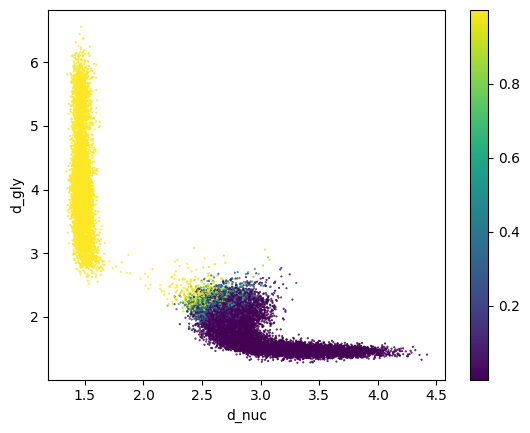

In [19]:
# model= torch.jit.load('./model_2.pt').to(torch.float64).to(device)
# model= torch.jit.load('/home/pkang@iit.local/work/committor/sudip/test_training/test2_cycle0/tracesave_cycle3_new_save0.9999/model_committor_cycle3_epoch24000.pt')
model= torch.jit.load('./model_test3_cycle2.pt').to(torch.float64)


# x= TranstoUnscaledcoord(dataset['data'].to(device),cell)
# d= preprocessing(x)
# d_use = d[:,[0,1,13,33,39,40,41,42,46,57,58,68]]
# print (len(d_use))
#d_use=d
#q = model(d_use)
#name_x = '23'
#name_y = '10'


# plt.scatter(d[:50000,43].detach().cpu(),d[:50000,44].detach().cpu(),c=q[:50000].cpu().squeeze().detach().numpy(),s=0.1,marker='.')
# plt.scatter(d[50000:,20].detach().cpu(),d[50000:,44].detach().cpu(),c=q[50000:].cpu().squeeze().detach().numpy(),s=0.1,marker='.')
plt.scatter(d[:,10].detach().cpu(),d[:,21].detach().cpu(),c=q[:].cpu().squeeze().detach().numpy(),s=1,marker='.')
plt.colorbar()

# plt.scatter(dataframe.loc[dataframe['labels']== 0, name_x], dataframe.loc[dataframe['labels']== 0, name_y], s=1, cmap='fessa')
# plt.scatter(dataframe.loc[dataframe['labels']== 1, name_x], dataframe.loc[dataframe['labels']== 1, name_y], s=1, cmap='fessa')
# plt.xlim(1.3,2.7)
# plt.ylim(0.9,1.5)
plt.xlabel('d_nuc')
plt.ylabel('d_gly')

(25183, 51)
(25183, 51)
(25183,)
564
[ 5.75169155  5.33525477  6.00208026  7.44336706  7.58133797  6.94337734
  6.05012376  1.28330133  1.28888716  3.20518526  2.65033309  3.07037696
  2.90033716  3.58412068  3.84519768  4.50410325  1.64789039  1.30859337
  5.07760487  1.10675693  1.51593431  2.2166749   5.93517278  6.38835812
  1.69545782  3.06855906  5.46178408  2.77874448  1.65009151  4.49362638
  4.71686711  8.20452984  1.44966846  1.07530995  3.57368124  4.80065679
  1.28033174  1.29501317  2.88208566  1.73366106  1.7497729   3.22137348
  2.77278481  3.11712274  2.98365779  4.82444689  4.37993833 -0.44368326
  0.72382649  0.0865619   0.74958921]


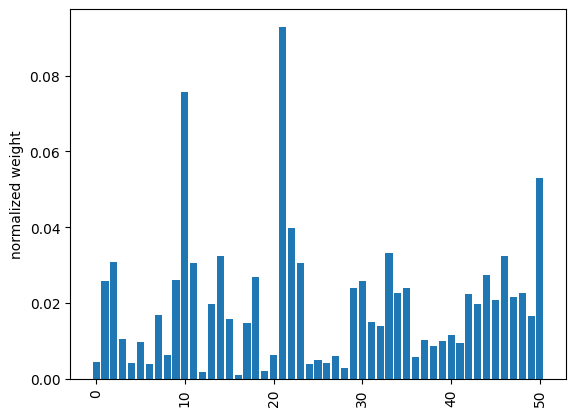

In [20]:
# x = dataset[:]['data']
# x.requires_grad = True
# x = x.to(device)
# if preprocessing is not None:
#     x= TranstoUnscaledcoord(x,cell)
#     d= preprocessing(x)
#     # d = preprocessing(x)
 
# d,grad_d= Generate_Discriptor(dataset['data'][:].to(device),cell, na=31) 
# d_use = d[:,[0,1,13,33,39,40,41,42,46,57,58,68]] 
data_tensor_d =d
data_d = data_tensor_d.cpu().detach().numpy()
idall = np.array(range(len(data_d)))
model= torch.jit.load('model_test3_cycle2.pt').to(torch.float64).to(device)
# model = torch.jit.load('./model_3.pt').to(torch.float64).to(device)
allq = model(d)
print (data_d.shape)
Hnew= allq.detach().cpu().numpy().squeeze()
#mask1= np.logical_and(Hnew > 0.0, Hnew < 1.0)    
mask1= np.logical_and(Hnew > 0.4, Hnew < 0.6)
# mask1= np.logical_and(Hnew < 0.1, Hnew < 0.02)
# mask1= np.logical_and(Hnew > 0.95, Hnew > 0.97)
#ene = dataframe['ene'].values
 
 
#ene= ene- np.min(ene[mask1])
 
# print (ene)
# mask1= np.logical_and(mask1, ene < 30)
 
print (data_d.shape)
print (mask1.shape)
data_d = data_d[mask1]
print (len(data_d))
id_TS = idall[mask1]
# print (len(id_TS))
# data_d = data_d[4000:,:]
# # print (mask1)
# mask1= np.logical_and(mask1,  np.equal(dataframe['time'].values, np.floor(dataframe['time'].values)) )
 
mean= np.mean(data_d,axis=0)
print (mean)
std_d= np.sqrt(np.mean(np.power(data_d- mean,2),axis= 0))
# model = torch.jit.load('model_9.pt').to(torch.float64).to(device)
# model = torch.jit.load('/home/pkang@iit.local/work/committor/dasa/dasa/tracesave_cycle11_new/model_committor_cycle11_epoch20000.pt').to(torch.float64).to(device)
 
d = data_tensor_d[mask1]
# d.requires_grad= True
H = model(d)
grad_output= torch.ones_like(H)
grad = torch.autograd.grad(H, d, grad_outputs=grad_output)[0]
 
s =np.sum(np.abs(grad.detach().cpu().numpy()),axis= 0)
 
s= s/np.sum(s) 
xlabel= range(51)
# print (len(xlabel))
plt.bar(xlabel,s)
#plt.bar(xlabel,std_d)

plt.xticks(rotation=90, ha='center')
plt.ylabel('normalized weight')
plt.show()

51
51
['d1-5', 'd1-6', 'd1-8', 'd1-10', 'd1-12', 'd1-13', 'd1-14', 'd2-3', 'd2-4', 'd3-5', 'd3-6', 'd3-8', 'd3-15', 'd4-5', 'd4-6', 'd4-8', 'd4-15', 'd5-6', 'd5-17', 'd6-7', 'd6-8', 'd6-16', 'd6-18', 'd8-19', 'd9-28', 'd9-29', 'd10-20', 'd11-28', 'd11-29', 'd12-21', 'd13-22', 'd14-23', 'd16-21', 'd16-27', 'd16-30', 'd23-30', 'd24-25', 'd24-26', 'd25-27', 'd25-32', 'd26-27', 'd26-30', 'd26-32', 'd27-31', 'd28-30', 'd29-30', 'd30-31', 'sin(phi)', 'cos(phi)', 'sin(psi)', 'cos(psi)']
[('d6-16', 0.09294311623590681), ('d3-6', 0.07574133636239198), ('cos(psi)', 0.05302270653952592), ('d6-18', 0.03978475027503941), ('d16-27', 0.03322605257999784), ('d4-6', 0.0324914906996053), ('d30-31', 0.03240527511776152), ('d1-8', 0.0307162274092865), ('d8-19', 0.030628170732381946), ('d3-8', 0.030529531775110814), ('d28-30', 0.02750046038928191), ('d5-17', 0.026950378683806), ('d3-5', 0.025966357786584505), ('d13-22', 0.02572929112949198), ('d1-6', 0.02569544501684449), ('d23-30', 0.024016523561297354), 

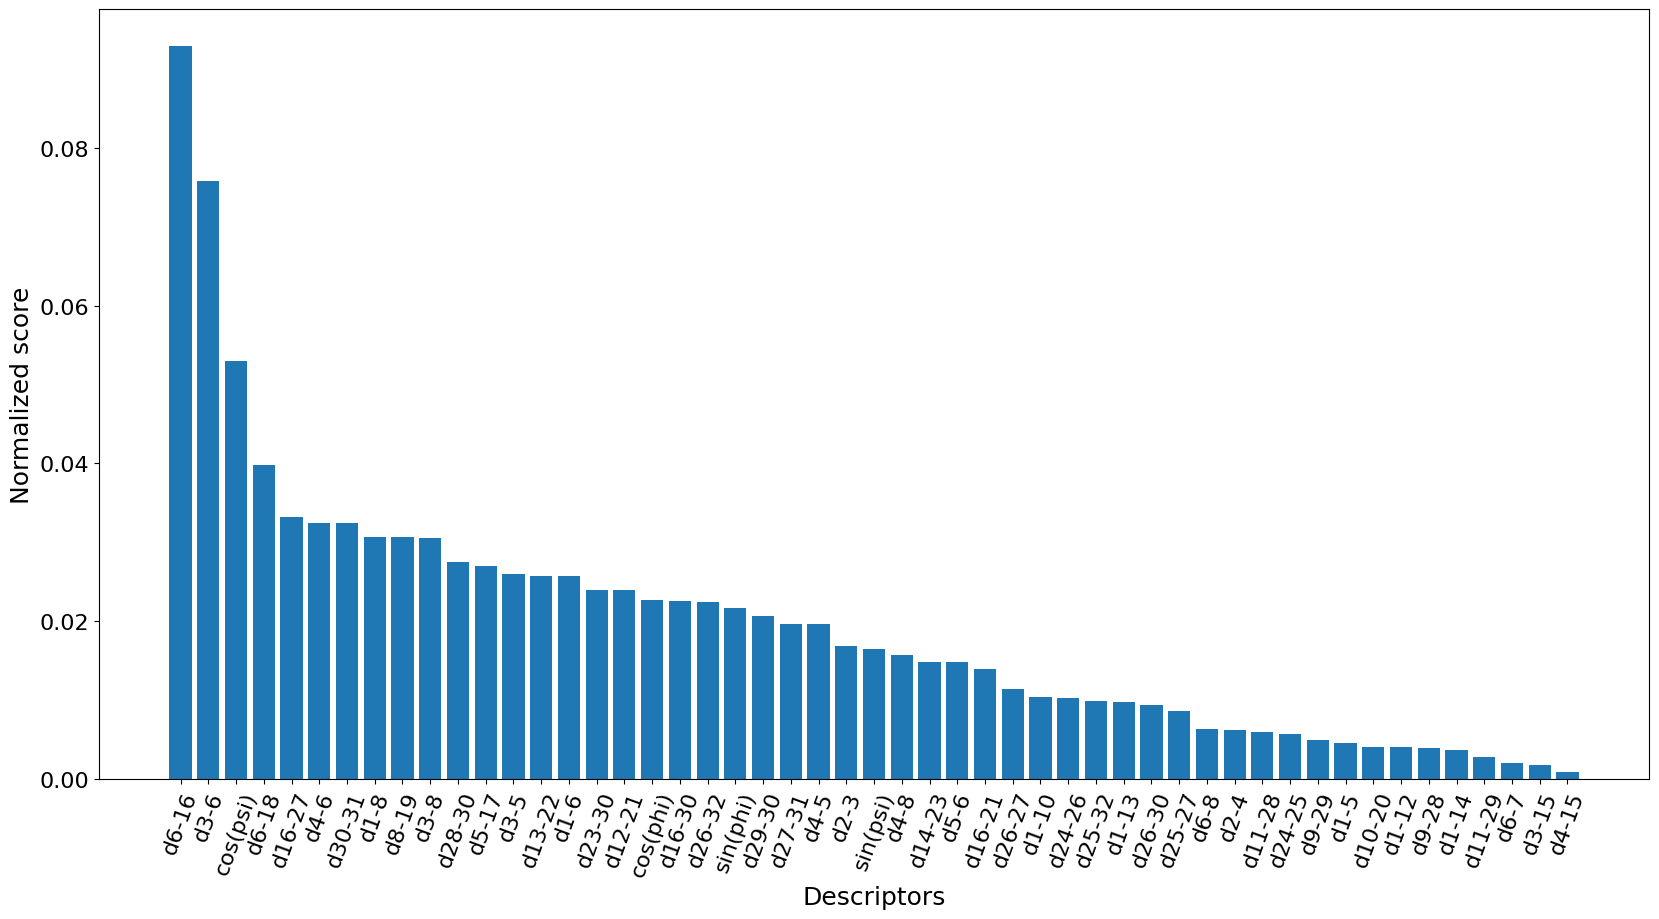

In [21]:
## namelist 
#namelist = ['C_Asp197_CA','C_Asp197_C','C_Asp197_O1','C_Asp197_O2','C_subst_O5','C_subst_C1','C_subst_C1H','C_subst_C2','C_subst_O2H','C_subst_C3','C_subst_O3H','C_subst_C4','C_subst_C5','C_subst_O6','C_subst_O6H','C_subst_Ogly','C_subst_O5dash','C_subst_C1dash','C_subst_C2dash','C_subst_C3dash','C_subst_C4dash','C_subst_C5dash','C_subst_O6dash','C_Glu233_C','C_Glu233_O1','C_Glu233_O2','C_Glu233_H','C_Asp300_O1','C_Asp300_O2','C_Water_O','C_subst_O2','C_subst_O3Hdash','C_Water_OH1','C_Water_OH2']
#natom= len(namelist)
#
#k=-1
#DescriptornameDict= {}
#for i in range(natom):
#    for j in range(i+1,natom):
#        k=k+1
#        disname= f'D_{namelist[i]}-{namelist[j]}'
#        # print (f'{k}, d{i+1}-{j+1}, D_{namelist[i]}-{namelist[j]}')
#        DescriptornameDict[disname]= [k,f'd{i+1}-{j+1}']
#
### we need a function to read plumed file
#disnamelist ='D_C_Asp197_CA-C_subst_O5,D_C_Asp197_CA-C_subst_C1,D_C_Asp197_CA-C_subst_C2,D_C_Asp197_CA-C_subst_C3,D_C_Asp197_CA-C_subst_C4,D_C_Asp197_CA-C_subst_C5,D_C_Asp197_CA-C_subst_O6,D_C_Asp197_C-C_Asp197_O1,D_C_Asp197_C-C_Asp197_O2,D_C_Asp197_O1-C_subst_O5,D_C_Asp197_O1-C_subst_C1,D_C_Asp197_O1-C_subst_C2,D_C_Asp197_O1-C_subst_O6H,D_C_Asp197_O2-C_subst_O5,D_C_Asp197_O2-C_subst_C1,D_C_Asp197_O2-C_subst_C2,D_C_Asp197_O2-C_subst_O6H,D_C_subst_O5-C_subst_C1,D_C_subst_O5-C_subst_O5dash,D_C_subst_C1-C_subst_C1H,D_C_subst_C1-C_subst_C2,D_C_subst_C1-C_subst_Ogly,D_C_subst_C1-C_subst_C1dash,D_C_subst_C1-C_Water_O,D_C_subst_C2-C_subst_C2dash,D_C_subst_O2H-C_Asp300_O1,D_C_subst_O2H-C_Asp300_O2,D_C_subst_C3-C_subst_C3dash,D_C_subst_O3H-C_Asp300_O1,D_C_subst_O3H-C_Asp300_O2,D_C_subst_C4-C_subst_C4dash,D_C_subst_C5-C_subst_C5dash,D_C_subst_O6-C_subst_O6dash,D_C_subst_Ogly-C_subst_C4dash,D_C_subst_Ogly-C_Water_O,D_C_subst_O6dash-C_Water_O,D_C_Glu233_C-C_Glu233_O1,D_C_Glu233_C-C_Glu233_O2,D_C_Glu233_O2-C_Water_O,D_C_Water_O-C_Water_OH1,D_C_Water_O-C_Water_OH2'
#
#disnamelist = disnamelist.split(',')
## print (disnamelist)
#
#sellist= []
#xlabels= []
#for disname in disnamelist:
#    sellist.append(DescriptornameDict[disname][0])
#    xlabels.append(DescriptornameDict[disname][1])
## print (sellist)
#
#xlabels.extend(['sin(phi)','cos(phi)','sin(psi)','cos(psi)'])
xlabels=['d1-5','d1-6','d1-8','d1-10','d1-12','d1-13','d1-14','d2-3','d2-4','d3-5','d3-6','d3-8','d3-15','d4-5','d4-6','d4-8','d4-15','d5-6','d5-17','d6-7','d6-8','d6-16','d6-18','d8-19','d9-28','d9-29','d10-20','d11-28','d11-29','d12-21','d13-22','d14-23','d16-21','d16-27','d16-30','d23-30','d24-25','d24-26','d25-27','d25-32','d26-27','d26-30','d26-32','d27-31','d28-30','d29-30','d30-31','sin(phi)','cos(phi)','sin(psi)','cos(psi)']
# xlabels=['d1-5','d1-6','d1-8','d1-10','d1-12','d1-13','d1-14','d2-3','d2-4','d3-5','d3-6','d3-8','d3-15','d4-5','d4-6','d4-8','d4-15','d5-6','d5-17','d6-7','d6-8','d6-16','d6-18','d6-30','d8-19','d9-28','d9-29','d10-20','d11-28','d11-29','d12-21','d13-22','d14-23','d16-21','d16-27','d16-30','d23-30','d24-25','d24-26','d25-27','d25-32','d25-33','d25-34','d26-27','d26-30','d26-32','d26-33','d26-34','d27-31','d28-30','d29-30','d30-31','sin(phi)','cos(phi)','sin(psi)','cos(psi)']
#xlabels=[]
 
#for i in range(32):
#    for j in range(i+1,32):
#        xlabels.append(f'd{i+1}-{j+1}')
print (len(xlabels))
print (len(s))
print (xlabels)

groupr = []
#for tt in zip(xlabels,s*std_d):
for tt in zip(xlabels,s):
    # print (tt)
    groupr.append(tt)
# print (len(groupr))
groupr.sort(key= lambda x: x[1], reverse=True)
print (groupr)
 
sortedx= []
sortedy = []
for r in groupr:
    sortedx.append(r[0])
    sortedy.append(r[1])
# plt.fig(8,20)
fig = plt.figure(figsize= (20,10))
 
plt.bar(sortedx,sortedy)
plt.xticks(rotation=70,fontsize =16)
#plt.xticks(rotation=60, ha='left',fontsize =16)
#plt.xticks(fontsize =14)
plt.yticks(fontsize =16)
plt.xlabel('Descriptors',fontsize =18)
plt.ylabel('Normalized score',fontsize =18)
#plt.title('Weights based on derivatives',fontsize =24)
plt.savefig('weights.png')

### Visualize sampling

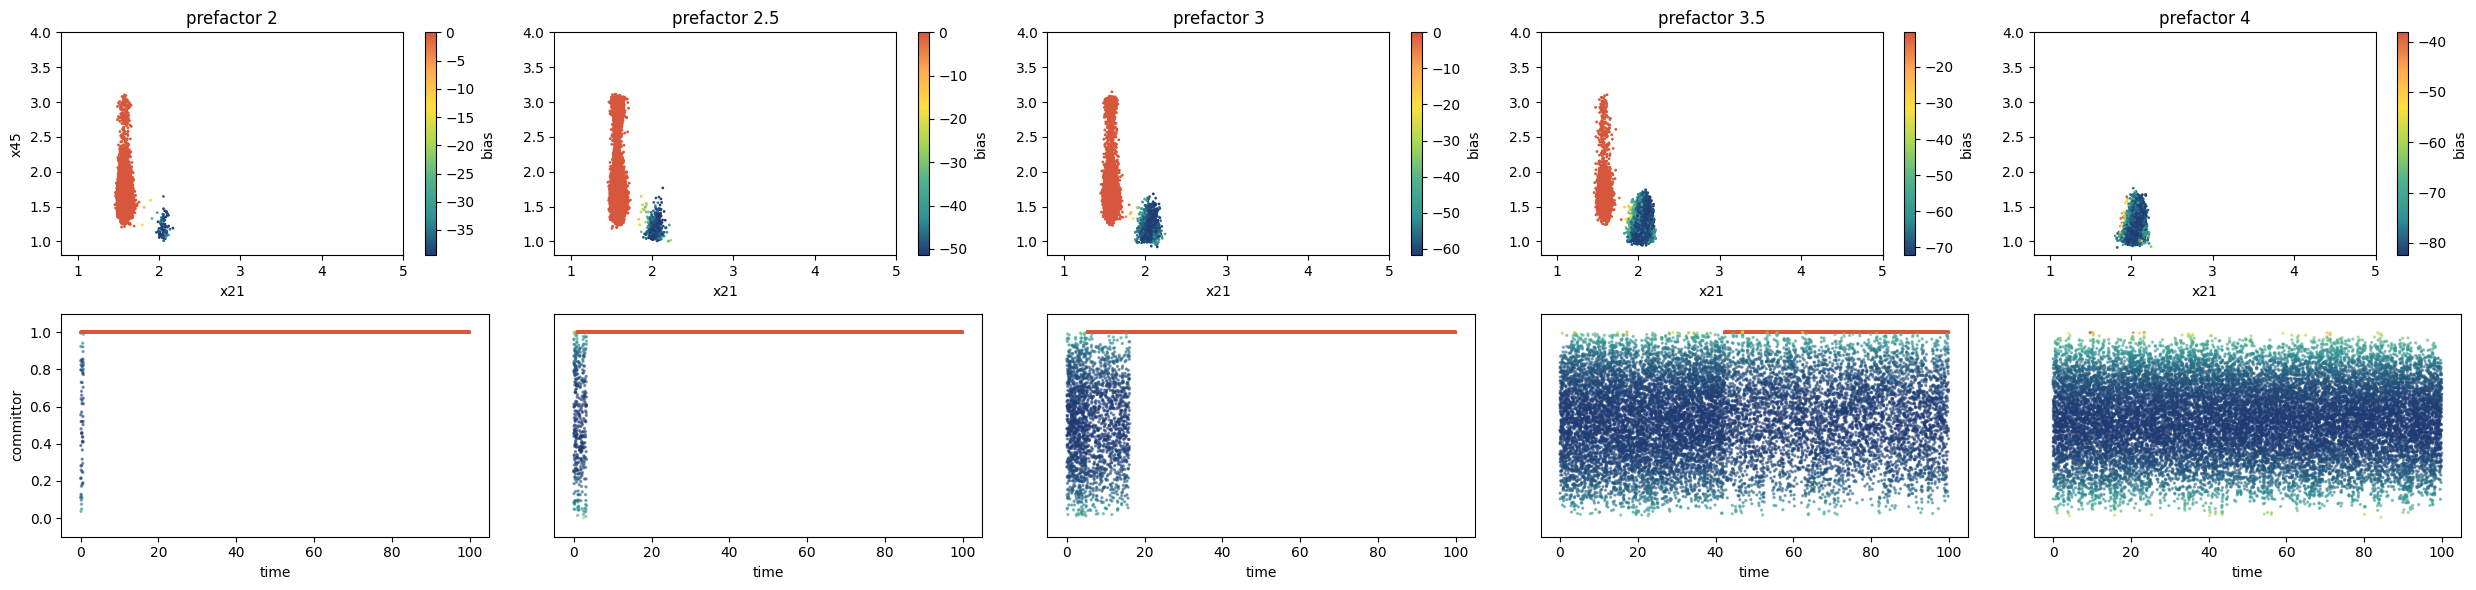

In [ ]:
## different labda values from simulations
#
## lambdas = [2, 3,3.5 ,4,5]
#lambdas = [ 2,2.5, 3,3.5 ,4]
#name_x = 'x21'
#name_y = 'x45'
#color_coding = 'bias'
## model to use for time series
#ref_model = torch.jit.load('sims/iter_2_3d/model_1_3d.pt')
#
## choose which simualtions to plot according to starting basin
## A, B = True, False
## A, B = False,True
#A, B = True, True
#
#
#ncols = len(lambdas)
#ffig, axs = plt.subplots(2,ncols,figsize=(5*ncols,6))
#for i in range(ncols):
#    a = lambdas[i]
#    ax = axs[0,i]
#
#    if A:
#        sampling_A = load_dataframe(f'sims/iter_12_new/lambda_{a}/I3/COLVAR', start=0, stop=100000)[:-10]
#        sampling_A['labels'] = 0
#        cp = ax.scatter(sampling_A[name_x], sampling_A[name_y], c=sampling_A[color_coding], s=1, cmap='fessa')
#    if B:
#        sampling_B = load_dataframe(f'sims/iter_12_new/lambda_{a}/P3/COLVAR', start=0, stop=100000)[:-10]
#        sampling_B['labels'] = 1
#        cp = ax.scatter(sampling_B[name_x], sampling_B[name_y], c=sampling_B[color_coding], s=1, cmap='fessa')
#    plt.colorbar(cp, ax=ax, label=color_coding)
#
#    ax.set_title(f'prefactor {a}')
#    ax.set_xlabel(name_x)
#
#    if i==0:
#        ax.set_ylabel(name_y)
#    else:
#        pass
#        # ax.yaxis.set_ticks([])
#    ax.set_ylim(0.8,4.0)
#    ax.set_xlim(0.8,5.0)
#
#    ax = axs[1,i]
#    if A: cp = ax.scatter(sampling_A['time'], sampling_A['q.node-0'], c=sampling_A[color_coding], alpha = 0.5, s=2, cmap='fessa')
#    if B: cp = ax.scatter(sampling_B['time'], sampling_B['q.node-0'], c=sampling_B[color_coding], alpha = 0.5, s=2, cmap='fessa')
#    ax.set_ylim(-0.1,1.1)
#    ax.set_xlabel('time')
#    if i==0:
#        ax.set_ylabel('committor')
#    else:
#        ax.yaxis.set_ticks([])
#
#plt.tight_layout()
#plt.show()

## For comparing different model

In [27]:
# check if we can stop with the iterations 
alpha_loss =1
# first we ensure that the committors are actually similar
previous_model = torch.jit.load('/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle0/model_test3_cycle0.pt').to(torch.float64).to(device)
# current_model = torch.jit.load().to(torch.float64).to(device)
current_model= torch.jit.load('/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle1/model_test3_cycle1.pt').to(torch.float64).to(device)
# current_model =torch.jit.load('/home/pkang@iit.local/work/committor/dasa/dasa/tracesave_cycle11_new/model_committor_cycle11_epoch4000.pt')

# x = dataset[:]['data']
# x.requires_grad = True
# x = x.to(device)
# if preprocessing is not None:
#     d = preprocessing(x)

xori = dataset[:]['data']
xori = xori.to(device)

d,grad_d= Generate_Discriptor(xori,cell, na=32)
d_use =d
print (d_use.shape)

labels = dataset[:]['labels']
w = dataset[:]['weights']
labels = labels.to(device)
w = w.to(device)


previous_data = previous_model(d_use)
current_data = current_model(d_use)

mse = torch.mean((previous_data.cpu() - current_data.cpu())**2)
print(mse)
# print(cell[0])
# then we check the losses
_, previous_loss  =  loss_function(x=x,
                                  q=previous_data,
                                  labels=labels,
                                  w=w,
                                  mass=atomic_masses,cell_size= cell[0],
                                  alpha=alpha_loss,)

_, current_loss =  loss_function(x=x,
                                  q=current_data,
                                  labels=labels,
                                  w=w,
                                  mass=atomic_masses,cell_size= cell[0],
                                  alpha=alpha_loss)

print(previous_loss[0])
print(current_loss[0])


previous_data1= previous_data

OutOfMemoryError: CUDA out of memory. Tried to allocate 656.00 MiB. GPU 0 has a total capacty of 7.78 GiB of which 290.19 MiB is free. Including non-PyTorch memory, this process has 6.96 GiB memory in use. Of the allocated memory 5.39 GiB is allocated by PyTorch, and 1.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
#current_model= torch.jit.load('/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle2/model_test3_cycle2.pt').to(torch.float64).to(device)

xori = dataset[:]['data']
xori = xori.to(device)

d,grad_d= Generate_Discriptor(xori,cell, na=32)
print (d.shape)

labels = dataset[:]['labels']
w = dataset[:]['weights']
labels = labels.to(device)
w = w.to(device)

# modify the namelist here
modellist = [
#            '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle0/model_0.pt',
#            '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle1/model_1_2.pt',
#            '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle2/model_2_1.pt',
#            '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle3/model_3_1.pt',
#            '/home/sudas@iit.local/work/TS_search_amylase/training/test2_cycle0/model_test2_cycle0.pt',
#            '/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle0/model_test3_cycle0.pt',
#           '/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle1_new/model_test3_cycle1.pt',
            '/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle2/model_test3_cycle2.pt',
            ]

results =[]

for modelname in modellist:
    model = torch.jit.load(modelname).to(torch.float64)
    current_data = model(d)

    loss, monitor = loss_function(x=d,
                                  q=current_data,
                                  dx= grad_d,
                                  labels=labels,
                                  w=w,
                                  mass=atomic_masses,
                                  gamma= 100000,
                                  delta_f = -8.35,    #deltaG (product - reactant), in kT unit
                                  alpha=1)

    results.append(monitor[0])

print (results)


[3, 4, 6, 8, 10, 11, 12, 31, 32, 62, 63, 65, 72, 90, 91, 93, 100, 118, 129, 145, 146, 154, 156, 206, 238, 239, 252, 281, 282, 294, 314, 333, 364, 370, 373, 457, 460, 461, 469, 474, 475, 478, 480, 484, 487, 490, 493]
torch.Size([27982, 3])
torch.Size([27982, 3])
torch.Size([27982, 51])
torch.Size([27982, 96, 51])
torch.Size([27982, 51])
[tensor(4.6249e-08, device='cuda:0')]


In [15]:
modellist = [
           # '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle0/model_0.pt',
           # '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle1/model_1_2.pt',
           # '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle2/model_2_1.pt',
           # '/home/sudas@iit.local/work/TS_search_amylase/training/test1_cycle3/model_3_1.pt',
           # '/home/sudas@iit.local/work/TS_search_amylase/training/test2_cycle0/model_test2_cycle0.pt',
           '/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle0/model_test3_cycle0.pt',
          '/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle1_new/model_test3_cycle1.pt',
            '/home/sudas@iit.local/work/TS_search_amylase/training/test3_cycle2/model_test3_cycle2.pt',
            ]

results =[]

for modelname in modellist:
    model = torch.jit.load(modelname).to(torch.float64)
    current_data = model(d)

    loss, monitor = loss_function(x=d,
                                  q=current_data,
                                  dx= grad_d,
                                  labels=labels,
                                  w=w,
                                  mass=atomic_masses,
                                  gamma= 100000,
                                  delta_f = -8.35,    #deltaG (product - reactant), in kT unit
                                  alpha=1)

    results.append(monitor[0])

print (results)

[tensor(3.3868e-08, device='cuda:0'), tensor(4.5053e-08, device='cuda:0'), tensor(4.6249e-08, device='cuda:0')]
